# Data preparation
Downloading the images and the shape predictor dat file.

In [ ]:
# Downloading the images and the shape predictor dat file
!wget https://cdn.getstickerpack.com/storage/uploads/sticker-pack/mr-bean/sticker_3.png?deba7685cd005fa024c41eec279c60d8-O image1.jpg
!wget https://cdn.britannica.com/05/156805-050-4B632781/Leonardo-DiCaprio-2010.jpg -O image2.jpg
!wget https://www.dropbox.com/s/rjoud2f6wk5rsc3/shape_predictor_68_face_landmarks.dat

# Load dependencies
Here we download the dependencies and set the initial parameters for the matplotlib plotting.

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams.update({'font.size': 18})

# Image preprocessing, loading the landmark dat file
In this step we are loading in the image, setting it to grayscale, and creating the mask with the same shape as the image. Also we are creating the detector and the predictor. The detector is later used to detect faces in an image, and the predictor loads in the shape_predictor_68_face_landmarks.dat file, which finds 68 landmarks on a person's face.

In [50]:
img1 = plt.imread("/content/image1.jpg")
img2 = plt.imread("/content/image2.jpg")
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
mask = np.zeros_like(gray1)
mask2 = np.zeros_like(gray2)

img2_new_face = np.zeros_like(img2) # Black image with the same size of the second image

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

# Cutting face from the image
In this step we are taking the face from the image and applying it on the mask we created earlier. 

First thing we do is detect the faces using the detector. We iterate over all the faces that were detected and use the predictor to find the landmarks. We iterate over all 68 landmarks and append (x, y) to the landmark_points array.
Next thing we do is create a convex hull on the points that the predictor found. Using cv2's function fillConvexPoly we can copy the convex hull found to the mask we declared in the beggining. Lastly, we use the cv2 bitwise_and function to copy the face inside the convex_hull from the original image to the mask's convex hull.

(0.0, 1.0, 0.0, 1.0)

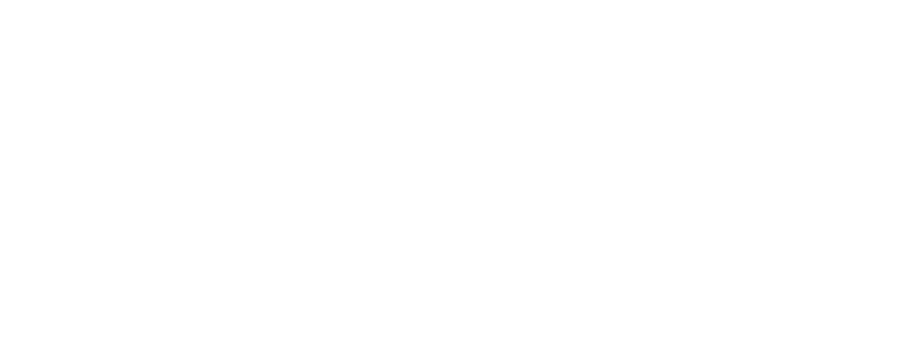

In [51]:
faces = detector(gray1)

for face in faces:
  landmarks = predictor(gray1, face)
  landmark_points = []

  for i in range(68):
    x = landmarks.part(i).x
    y = landmarks.part(i).y

    landmark_points.append((x, y))

    #cv2.circle(img1, (x, y), 3, (255, 0, 0), 5)
  
  points = np.array(landmark_points, np.int32)
  convexhull = cv2.convexHull(points)

  #cv2.polylines(img1, [convexhull], True, (0, 0, 255), 3)
  cv2.fillConvexPoly(mask, convexhull, 255)

face_image1 = cv2.bitwise_and(img1, img1, mask=mask)
plt.axis('off')

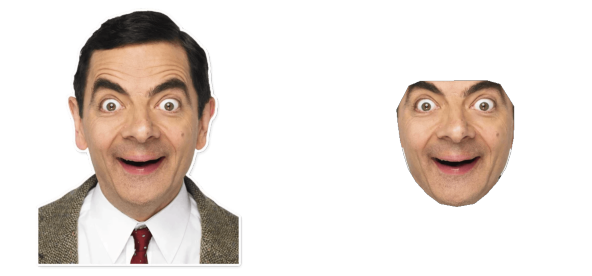

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.imshow(img1)

ax2 = fig.add_subplot(132)
ax2.imshow(face_image1)

ax1.axis('off')
ax2.axis('off')
plt.show()

# Delaunav triangulation
Here we are finding the delaunav triangulation. We first have to specify the rectangle in which we want to find them. As we already have the convex hull around the face we can use opencv's function "boundingRect" to select the renctangle around the face. We can draw the rectangle to see how it looks.

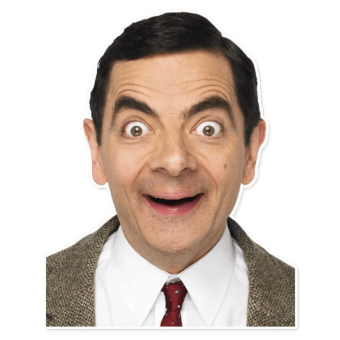

In [53]:
rect = cv2.boundingRect(convexhull)
(x, y, w, h) = rect
#cv2.rectangle(img1, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.axis('off')
plt.imshow(img1)

After finding the rectangle we can continue and find the triangles. For this we use the function "Subdiv2D" which will give us the triangles. We insert the landmark points into the subdiv we created. After that we can get our triangles. We iterate over all of the triangles, which are in format [t0, t1, t2, t3, t4, t5], and we create 3 points with them. Let's draw the lines and see how our triangles look on the image.

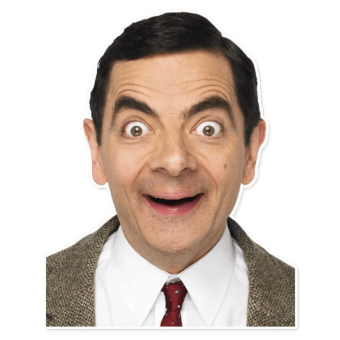

In [54]:
subdiv = cv2.Subdiv2D(rect)
subdiv.insert(landmark_points)
triangles = subdiv.getTriangleList()
traingles = np.array(triangles, np.int32)

for t in triangles:
  pt1 = (t[0], t[1])
  pt2 = (t[2], t[3])
  pt3 = (t[4], t[5])
  
  #cv2.line(img1, pt1, pt2, (255, 0, 0), 2)
  #cv2.line(img1, pt2, pt2, (255, 0, 0), 2)
  #cv2.line(img1, pt2, pt3, (255, 0, 0), 2)

plt.axis('off')
plt.imshow(img1)

There is one problem, we cannot do the same proccess on the second image. That is because different faces have different landmark points, also the triangles vary between faces. We can solve this problem by finding the index of each triangle corresponding to the landmark point.

If we print any the points pt1 we can see that it is the same as the landmark points. There is a np function that we can use to find the landmark points corresponding to the triangle points, it is the function "where".

After that we want to check if the indexes were found, if they were found we will append them into the array "triangle_indexes"

In [55]:
#Function for extracting number from array

def extract_index(arr):
  inde = None
  for num in arr[0]:
    index = num
    break
  return index

In [56]:
triangle_indexes = []
for t in triangles:
  pt1 = (t[0], t[1])
  pt2 = (t[2], t[3])
  pt3 = (t[4], t[5])

  index_pt1 = np.where((points == pt1).all(axis=1))
  index_pt1 = extract_index(index_pt1)

  index_pt2 = np.where((points == pt2).all(axis=1))
  index_pt2 = extract_index(index_pt2)
  
  index_pt3 = np.where((points == pt3).all(axis=1))
  index_pt3 = extract_index(index_pt3)

  if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
    triangle = [index_pt1, index_pt2, index_pt3]

    triangle_indexes.append(triangle)

  # Second image
  For the second face we know all the indexes so we need to loop through all the triangles and create them.

In [57]:
faces2 = detector(gray2)

img_copy1 = img1
img_copy2 = img2

for face in faces2:
  landmarks = predictor(gray2, face)
  landmark_points2 = []

  for i in range(68):
    x = landmarks.part(i).x
    y = landmarks.part(i).y

    landmark_points2.append((x, y))

In [59]:
img_copy2 = img2.copy()
img_copy1 = img1.copy()

for triangle_index in triangle_indexes:
  tr1_pt1 = landmark_points[triangle_index[0]]
  tr1_pt2 = landmark_points[triangle_index[1]]
  tr1_pt3 = landmark_points[triangle_index[2]]
  triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

  rect1 = cv2.boundingRect(triangle1) # Finding a rectangle around triangle
  (x, y, w, h) = rect1
  #cv2.rectangle(img_copy1, (x, y), (x+w, y+h), (255, 255, 0), 2)
  cropped_triangle1 = img_copy1[y:y+h, x:x+w] # Cropping the rectangle
  cropped_tr1_mask = np.zeros((h, w), np.uint8)
  
  points1 = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                    [tr1_pt2[0] - x, tr1_pt2[1] - y],
                    [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

  cv2.fillConvexPoly(cropped_tr1_mask, points1, 255)
  cropped_triangle1 = cv2.bitwise_and(cropped_triangle1, cropped_triangle1, mask=cropped_tr1_mask)

  #cv2.line(img_copy1, tr1_pt1, tr1_pt2, (255, 0, 0), 2)
  #cv2.line(img_copy1, tr1_pt2, tr1_pt3, (255, 0, 0), 2)
  #cv2.line(img_copy1, tr1_pt3, tr1_pt1, (255, 0, 0), 2)


  tr2_pt1 = landmark_points2[triangle_index[0]]
  tr2_pt2 = landmark_points2[triangle_index[1]]
  tr2_pt3 = landmark_points2[triangle_index[2]]
  triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)

  rect2 = cv2.boundingRect(triangle2) # Finding a rectangle around triangle
  (x, y, w, h) = rect2
  #cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (255, 255, 0), 2)
  cropped_triangle2 = img_copy2[y:y+h, x:x+w] # Cropping the rectangle
  cropped_tr2_mask = np.zeros((h, w), np.uint8)
  
  points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                    [tr2_pt2[0] - x, tr2_pt2[1] - y],
                    [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

  cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)
  cropped_triangle2 = cv2.bitwise_and(cropped_triangle2, cropped_triangle2, mask=cropped_tr2_mask)

  #cv2.line(img_copy2, tr2_pt1, tr2_pt2, (255, 0, 0), 2)
  #cv2.line(img_copy2, tr2_pt2, tr2_pt3, (255, 0, 0), 2)
  #cv2.line(img_copy2, tr2_pt3, tr2_pt1, (255, 0, 0), 2)

  # Warp points
  points1 = np.float32(points1)
  points2 = np.float32(points2)

  M = cv2.getAffineTransform(points1, points2)
  warped_triangle = cv2.warpAffine(cropped_triangle1, M, (w, h))

  # Reconstruction of second image
  triangle_area = img2_new_face[y:y+h, x:x+w]
  triangle_area = cv2.add(triangle_area, warped_triangle)
  #plt.imshow(triangle_area)

  img2_new_face[y:y+h, x:x+w] = triangle_area

error: ignored

(-0.5, 1439.5, 749.5, -0.5)

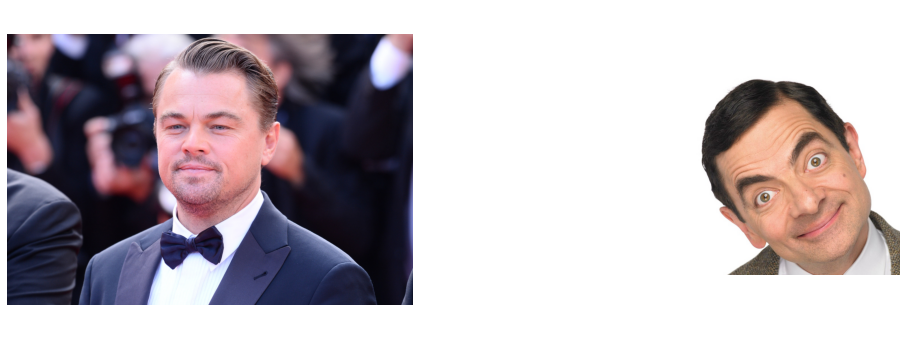

In [40]:
fig = plt.figure()

ax = fig.add_subplot(121)
ax.imshow(img_copy1)
ax.axis('off')

ax1 = fig.add_subplot(122)
ax1.imshow(img_copy2)
ax1.axis('off')
ax.axis('equal')
ax1.axis('equal')


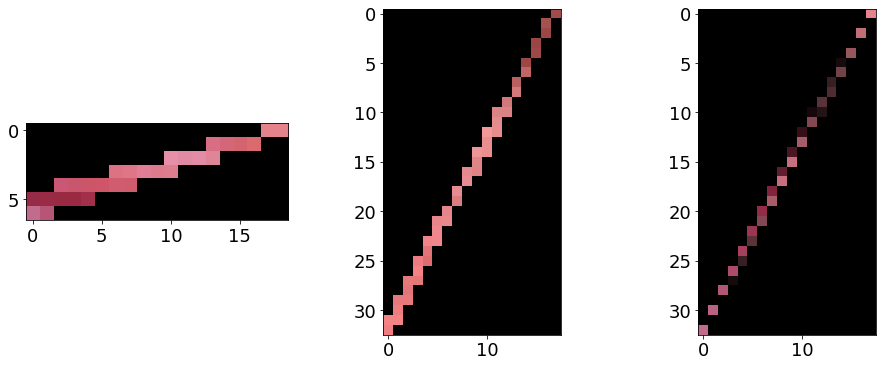

In [41]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(cropped_triangle1)

ax1 = fig.add_subplot(132)
ax1.imshow(cropped_triangle2)

ax1 = fig.add_subplot(133)
ax1.imshow(warped_triangle)

(-0.5, 1439.5, 749.5, -0.5)

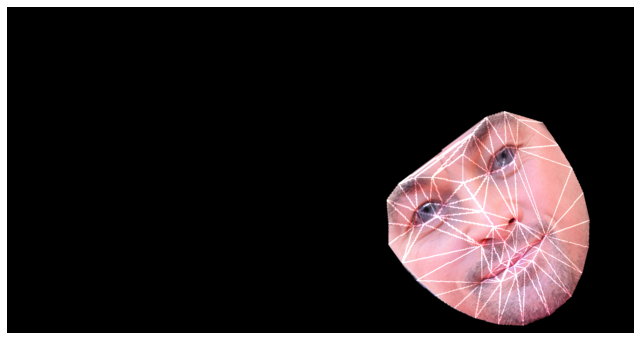

In [42]:
plt.imshow(img2_new_face)
plt.axis('off')

# Face swap, placing the first face to the second

In [43]:
img2_new_face_gray = cv2.cvtColor(img2_new_face, cv2.COLOR_BGR2GRAY)
_, background = cv2.threshold(img2_new_face_gray, 1, 255, cv2.THRESH_BINARY_INV)
background = cv2.bitwise_and(img2, img2, mask=background)

result = cv2.add(background, img2_new_face)

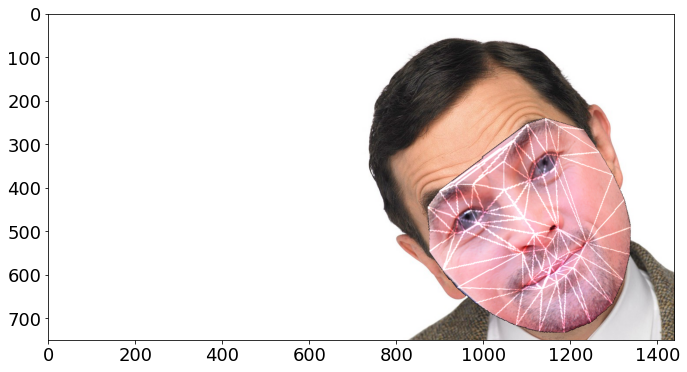

In [44]:
plt.imshow(result)

In [45]:
np_points2 = np.array(landmark_points2, np.int64)
convexhull2 = cv2.convexHull(np_points2)
cv2.fillConvexPoly(mask2, convexhull2, 255)

(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))

seamlessclone = cv2.seamlessClone(result, img2, mask2, center_face2, cv2.MIXED_CLONE)

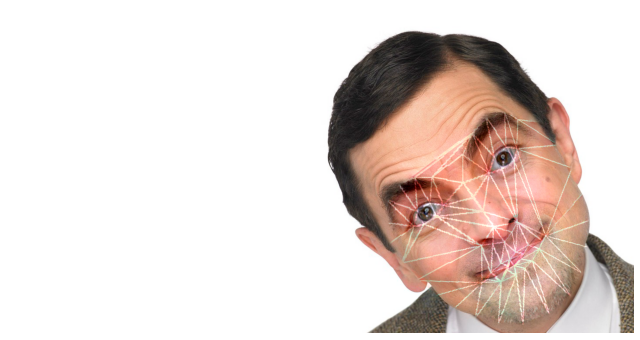

In [46]:
plt.axis('off')
plt.imshow(seamlessclone)

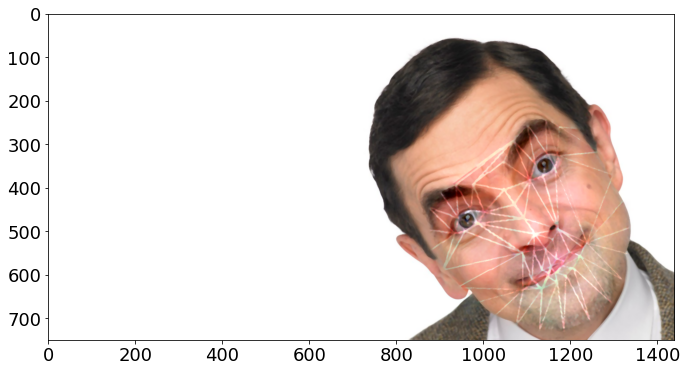

In [47]:
blurred = cv2.medianBlur(seamlessclone, 5)
plt.imshow(blurred)

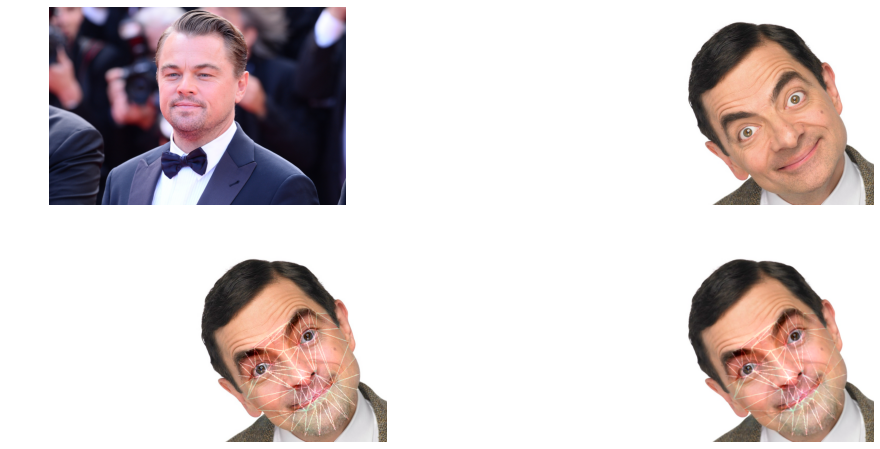

In [48]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(2, 2, 1)
ax.imshow(img1)
ax.axis('off')

ax1 = fig.add_subplot(2, 2, 2)
ax1.imshow(img2)
ax1.axis('off')

ax2 = fig.add_subplot(2, 2, 3)
ax2.imshow(seamlessclone)
ax2.axis('off')

ax3 = fig.add_subplot(2, 2, 4)
ax3.imshow(blurred)
ax3.axis('off')

plt.show()